# Background




+ First we import the python packages and create a series of functions.

+ Then we open each image, roate it, extract its coordinates, and save it as a `*.tiff` file.

+ Later we transform the coordinates of each image from Decimal Degrees to Eastings and Northings. This will allow us to create a `*.tfw` file for each `*.tiff` image.
    
+ Finally we create the `*.tfw` file. 

Once we create the `*.tiff` and `*.tfw` files, we can project them and upload the images to Google Earth Engine

*Note: We assume that the reader has the required knowledge to use Jupyter notebooks or run this code in another development environment. 



# Getting Started

## Load python packages

In the following cell we import tha python packages we'll use in this example.

In [1]:
import gdal
import os
import sys
import glob
import time 
import subprocess
import pandas as pd
from PIL import Image

## Find the `*.jpeg` files
Now, we look for the directory or folder where the drone images are located.
Here, we're interested only in `*.jpg` files, so we ensure that we only find those.

In [2]:
# Locate the directory of folder
path_1 ='C:/Users/mkben/Desktop/Demo Drone JPEGS'
# path_1 = 'C:/droneImages/'

# Find all `*.jpeg` files in the directory or folder
os.chdir(path_1)
files = glob.glob("*.JPG")

# Print the number of `*.jpeg` files in the folder
print('there are ', len(files), ' *.jpeg files in ', os.getcwd())

there are  5  *.jpeg files in  C:\Users\mkben\Desktop\Demo Drone JPEGS


Now that we know how many images we have, and their location, we can begin the image processing

# Create the functions

In this step, we create some functions that will help us keep our code clean.
The first fucntion roates the images 180 degrees, and saves it as `*.tiff`.
The second function uses `exiftool` to extract the metadata from the images
the third function creates a `*.tfw` file for each image. See more about `*.tfw` files here (https://en.wikipedia.org/wiki/World_file)

In [3]:
# Function to rotate the JPEG and save image as TIFF
def rotate_image(file):
    ''' This function uses the PIL packages to open, rotate, and save an image.
    :: file: a string with the image file name
    :: returns a `*.tiff` image
    '''
    with Image.open(file) as im:
#         Give the file a name
        basename = os.path.splitext(file)[0]
#     Rotate the image
        im = im.rotate(180)
#     Save the image as *.tiff
        im.save(str(basename)+'.tiff', format='TIFF')
        print(basename, ' rotated 180deg and saved as TIFF')

In [4]:
# Function to get the Lat and Lon values from the metadata of the images
def get_lat_lon(file):
    '''this function gets the latitude and longitude values from an image using the "exiftool"
    and exports it to a pandas DataFrame. To use the 'exiftool', ensure that the executable file
    'exiftool(-k).exe' is in the folder where the images are located.
    ::file (string): the file to extract the metadata from
    Returns pandas Dataframe.
    '''
    exe = 'exiftool(-k).exe' #ensure EXIFtool is on your working directory
    metadata = {}
    cols = ['Image_ID', 'Lat_dd', 'Lon_dd']
    lat_lon = pd.DataFrame(columns=cols)
    #execute exiftool to get the metadata
    process = subprocess.Popen([exe, file], stdout = subprocess.PIPE, 
                               stderr = subprocess.STDOUT,
                              universal_newlines = True)
    #parse each line and store it in a dictionary
    for output in process.stdout:
        #print(output.strip().split(':'))
        info = {}
        line = output.strip().split(':')
        try: 
            key = line[0].strip()
            value = line[1].strip()
            metadata[key] = value
        except IndexError as e:
            print(e)
    #transform the dictionary to pandas DataFrame
    metadata = pd.DataFrame.from_dict(metadata, orient='index')
    # Get the Latitude and logitude and transform D-M-S to Decimal Degrees
    lat_dms = str(metadata.loc['GPS Latitude'])
    lat_dms = lat_dms.replace("'",'').replace('"','').split(' ')
    lat_dd = int(lat_dms[4]) + int(lat_dms[6])/60 + float(lat_dms[7])/3600
    lon_dms = str(metadata.loc['GPS Longitude'])
    lon_dms = lon_dms.replace("'",'').replace('"','').split(' ')
    lon_dd = int(lon_dms[4]) + int(lon_dms[6])/60 + float(lon_dms[7])/3600
    #create a dataframe of lats and lons
    basename = os.path.splitext(file)[0]
    #here, the latitude has to be negative to be in the correct location
    df2 = pd.DataFrame([[basename, '-'+str(lat_dd), lon_dd]],
                       columns = cols)
    lat_lon = lat_lon.append(df2)
    return lat_lon

In [5]:
# Create a `*.tfw` file for each image
def create_tfw(file, csv_file):
    '''This function creates a tfw file with the eastings and northings 
    for each image.
    :: file (string): *.jpeg file to be transformed
    :: csv_file: CSV file with the eastings and northings of each `file`
    Returns a *.tfw file
    '''  
    #give a name to the file
    basename = os.path.splitext(file)[0]
       
    #Get the Eastings and Northings from the csv file   
    easting  = float(eastings[eastings['Image_ID'] == basename]['X'].values.round(3))
    northing = float(eastings[eastings['Image_ID'] == basename]['Y'].values.round(3))
    
    #create the *.twf file to store the eastings and northings for each file
    tfw = ('0.0045884815\n0.0000000000\n0.0000000000\n-0.0045884815\n'+
       str(easting)+'\n'+str(northing))
    
    with open(basename+'.tfw', "w") as file:
        file.write(str(tfw))       
    
    print(basename, 'has a new *.tfw file')

# Lets put it into practice:


In [6]:
# Print the working directory to ensure that this is where the images are stored
print(os.getcwd())

C:\Users\mkben\Desktop\Demo Drone JPEGS


In [7]:
# Use the 'rotate_image' function on each image. 
for file in files:
    rotate_image(file)

DJI_0002  rotated 180deg and saved as TIFF
DJI_0003  rotated 180deg and saved as TIFF
DJI_0004  rotated 180deg and saved as TIFF
DJI_0005  rotated 180deg and saved as TIFF
DJI_0006  rotated 180deg and saved as TIFF


In [8]:
# Create an empty pandas DataFrame to store the coordinates of all images
coordinates = pd.DataFrame()

#iterate though the folder where the files are
for file in files: 
    print('working on ', file)

    # Extract the latitude and logitude of each image using the 'get_lat_lon' function.
    coords = get_lat_lon(file)
    
    # Add the coordindates of each file to the 'coordinates' DataFrame
    coordinates = coordinates.append(coords)
    
# Export the DataFrame with the coordinates for all images to a `*.csv` file
coordinates.to_csv('coordinates.csv')

working on  DJI_0002.JPG
list index out of range
working on  DJI_0003.JPG
list index out of range
working on  DJI_0004.JPG
list index out of range
working on  DJI_0005.JPG
list index out of range
working on  DJI_0006.JPG
list index out of range


## Now `coordinates.csv` has the coordinates for all images in Decimal Degrees.

As part of the quality control of this project, we deliberately decided to run the following steps manually in QGIS. this way, we ensured that the extracted coordinates place the drone images in the correct location. We need to change these coordinates to Eastings and Northings. For simplicity, we use the QGIS User Interface in the following way:

1. Open Qgis
2. Click on *Open Data Source Mangager* and select *delimited text*
3. File Name --> `coordinates.csv`. 
4. Ensure that on the **geometry CRS** you select ESPG:4236 - WGS 84 (projection for Heron Reef) as shown below. This process will result in a new point layer showing the latitude and longitude coordinates of each image (from the 'coordinates.csv' file).

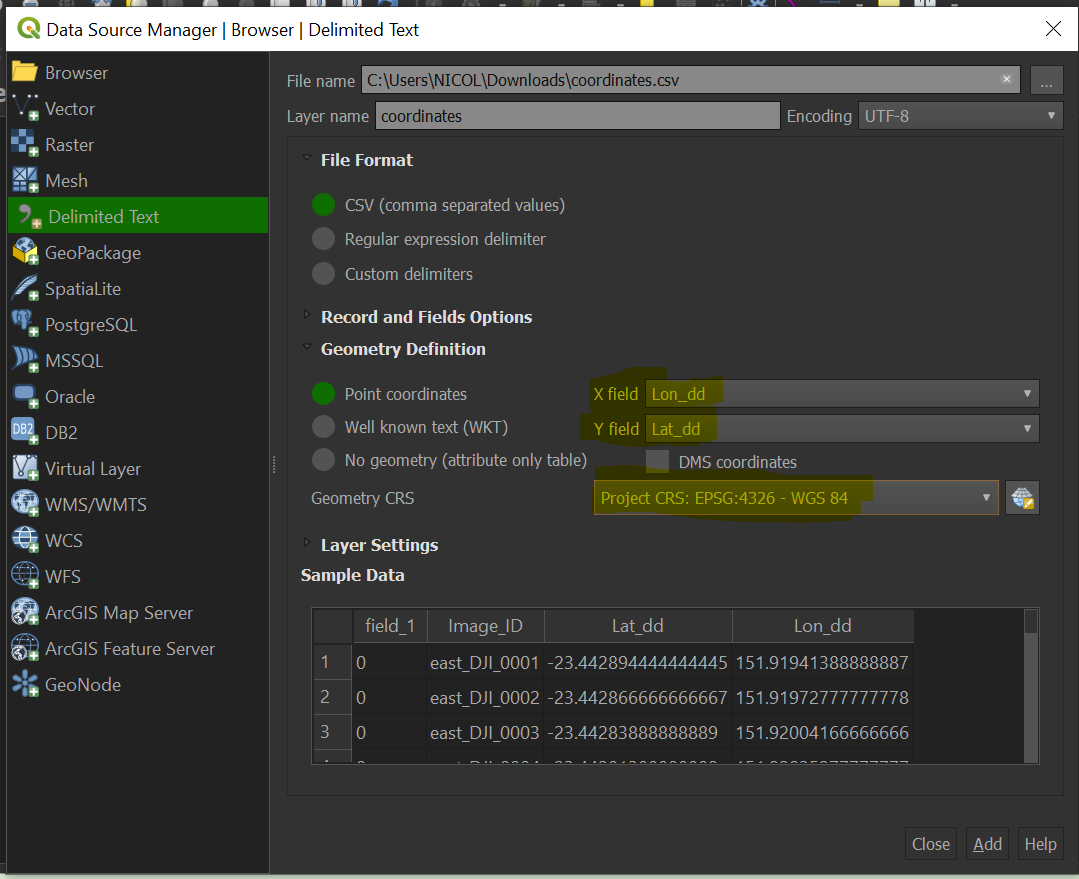

5. Right click on the new layer --> Export --> Save feature as. This opens a dialogue table
6. Select: a)`CSV` as output format, b)the de desired CRS (in this case UTM 56S) and c) `XY` as the geometry (i.e. longitude will be the first column and latitude the second column)

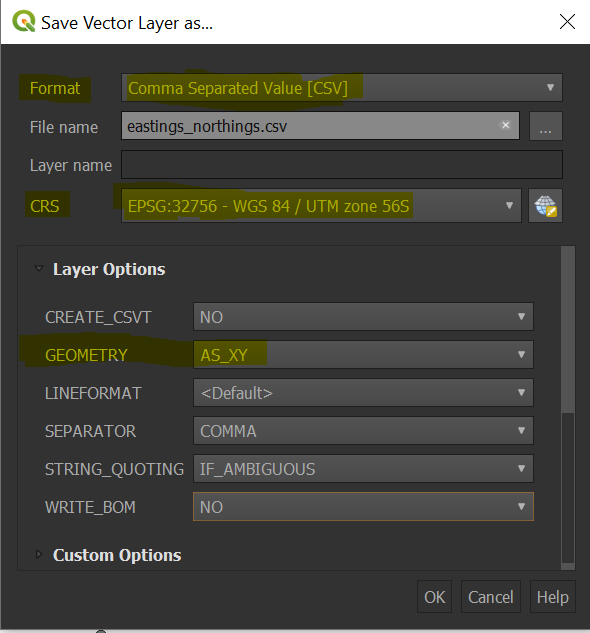

# Read the eastings and northings

Now that we have the coordinates of each image in Eastings and Northings, we can proceed to create the `*.tfw` file for each image.

In [9]:
# Read the *.csv file where the eastings and northings are located.
eastings = pd.read_csv('eastings_northings.csv')

# Print the first 5 records of the file
eastings.head(5)

,X,Y,field_1,Image_ID,Lat_dd,Lon_dd
0,-1.563725e+06,2.999593e+07,0,DJI_0002,-23.440203,151.912889
1,-1.563737e+06,2.999593e+07,0,DJI_0003,-23.439958,151.913181
2,-1.563750e+06,2.999593e+07,0,DJI_0004,-23.439711,151.913472
3,-1.563762e+06,2.999593e+07,0,DJI_0005,-23.439467,151.913761
4,-1.563776e+06,2.999593e+07,0,DJI_0006,-23.439178,151.913997


# What goes into a `*.tfw` file?

To create the `*.tfw` files, we need to understand what information they must have.
Each file has six rows, and each row has only one number. Below we explain the information in the file:

+ 0.0045884815  -> This is the x resolution. In this case ~0.45cm

+ 0.0000000000  -> Rotation in the X axix. In this case there is no rotation, hence the number is zero

+ 0.0000000000  -> Rotation in the Y axis. In this case there is no rotation, hence the number is zero

+ -0.0045884815 -> Y scale (i.e. x resolution). Normally negative because the 'origin' of the image is usually in the top left corner. In this case ~0.45cm

+ 389010.333    -> Easting coordinate of each iamge

+ 12592615.666  -> Northing coordinate of each iamge


In our case, because the only parameters that change are the Eastings and Northings while the other paramenters remain constant. Our `create_tfw` function reflects this.

We can now create the `*.tfw` files for each `*.tiff` image.

In [10]:

for file in files:
    create_tfw(file, eastings)         

DJI_0002 has a new *.tfw file
DJI_0003 has a new *.tfw file
DJI_0004 has a new *.tfw file
DJI_0005 has a new *.tfw file
DJI_0006 has a new *.tfw file


Now the images are ready to upload into Google Earth Engine or other software.

# License

**License:** The code in this notebook is licensed under the Creative Commons by Attribution 4.0 license.

**Last modified:** August 2020